<a href="https://colab.research.google.com/github/divyam123-EECS-Physics/NetLoadForecastingScripts/blob/main/Oregon_PyTorch2_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
!pip install solarforecastarbiter
!pip install TimezoneFinder

import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday

# from gluonts.mx.model.deep_npts import DeepNPTSEstimator
import torch
import scipy as sp

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, 

In [ ]:

training_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/oregon_historical.csv')
test_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/oregon_2023-06-30_test.csv')

# Feature engineering


In [ ]:
training_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)
test_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)

training_data.drop(columns = 'quality_flag', inplace = True)
test_data.drop(columns = 'quality_flag', inplace = True)

In [ ]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
0,2023-06-01 01:00:00,0.281151,8.1,76,4.2,6.1,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
1,2023-06-01 02:00:00,0.280982,7.2,77,3.5,5.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
2,2023-06-01 03:00:00,0.291136,6.5,78,2.9,4.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
3,2023-06-01 04:00:00,0.302375,5.6,80,2.5,3.2,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
4,2023-06-01 05:00:00,0.345335,5.0,80,1.9,2.5,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,31.6,19,5.1,28.8,0.0,0,0,0,0,373.0,321.0,52.0,832.2,2023-07-03T21:05,2023-07-03T05:29
787,2023-07-03 20:00:00,NaN,27.9,29,8.2,26.3,0.0,0,0,0,0,192.0,153.0,39.0,723.6,2023-07-03T21:05,2023-07-03T05:29
788,2023-07-03 21:00:00,NaN,21.7,47,9.9,20.3,0.0,0,0,0,0,41.0,26.0,15.0,369.3,2023-07-03T21:05,2023-07-03T05:29
789,2023-07-03 22:00:00,NaN,17.5,64,10.6,16.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-07-03T21:05,2023-07-03T05:29


In [ ]:
training_data.time = pd.to_datetime(training_data.time)
test_data.time = pd.to_datetime(test_data.time)

In [ ]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
0,2023-06-01 01:00:00,0.281151,8.1,76,4.2,6.1,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
1,2023-06-01 02:00:00,0.280982,7.2,77,3.5,5.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
2,2023-06-01 03:00:00,0.291136,6.5,78,2.9,4.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
3,2023-06-01 04:00:00,0.302375,5.6,80,2.5,3.2,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
4,2023-06-01 05:00:00,0.345335,5.0,80,1.9,2.5,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,31.6,19,5.1,28.8,0.0,0,0,0,0,373.0,321.0,52.0,832.2,2023-07-03T21:05,2023-07-03T05:29
787,2023-07-03 20:00:00,NaN,27.9,29,8.2,26.3,0.0,0,0,0,0,192.0,153.0,39.0,723.6,2023-07-03T21:05,2023-07-03T05:29
788,2023-07-03 21:00:00,NaN,21.7,47,9.9,20.3,0.0,0,0,0,0,41.0,26.0,15.0,369.3,2023-07-03T21:05,2023-07-03T05:29
789,2023-07-03 22:00:00,NaN,17.5,64,10.6,16.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-07-03T21:05,2023-07-03T05:29


In [ ]:
training_data['hours'] = (training_data.time.dt.hour - 12) / 24
test_data['hours'] = (test_data.time.dt.hour - 12) / 24

In [ ]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours
0,2023-06-01 01:00:00,0.281151,8.1,76,4.2,6.1,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27,-0.458333
1,2023-06-01 02:00:00,0.280982,7.2,77,3.5,5.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27,-0.416667
2,2023-06-01 03:00:00,0.291136,6.5,78,2.9,4.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27,-0.375000
3,2023-06-01 04:00:00,0.302375,5.6,80,2.5,3.2,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27,-0.333333
4,2023-06-01 05:00:00,0.345335,5.0,80,1.9,2.5,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27,-0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,31.6,19,5.1,28.8,0.0,0,0,0,0,373.0,321.0,52.0,832.2,2023-07-03T21:05,2023-07-03T05:29,0.291667
787,2023-07-03 20:00:00,NaN,27.9,29,8.2,26.3,0.0,0,0,0,0,192.0,153.0,39.0,723.6,2023-07-03T21:05,2023-07-03T05:29,0.333333
788,2023-07-03 21:00:00,NaN,21.7,47,9.9,20.3,0.0,0,0,0,0,41.0,26.0,15.0,369.3,2023-07-03T21:05,2023-07-03T05:29,0.375000
789,2023-07-03 22:00:00,NaN,17.5,64,10.6,16.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-07-03T21:05,2023-07-03T05:29,0.416667


In [ ]:
test_data['sunrise'] = pd.to_datetime(test_data.sunrise)
test_data['sunset'] = pd.to_datetime(test_data.sunset)

test_data.sunrise = ((test_data.sunrise.dt.hour - 12) / 24) + ((test_data.sunrise.dt.minute - 30) / 60)
test_data.sunset = ((test_data.sunset.dt.hour - 12) / 24) + ((test_data.sunset.dt.minute - 30) / 60)

In [ ]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours
0,2023-06-01 01:00:00,0.281151,8.1,76,4.2,6.1,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.733333,-0.341667,-0.458333
1,2023-06-01 02:00:00,0.280982,7.2,77,3.5,5.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.733333,-0.341667,-0.416667
2,2023-06-01 03:00:00,0.291136,6.5,78,2.9,4.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.733333,-0.341667,-0.375000
3,2023-06-01 04:00:00,0.302375,5.6,80,2.5,3.2,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.733333,-0.341667,-0.333333
4,2023-06-01 05:00:00,0.345335,5.0,80,1.9,2.5,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.733333,-0.341667,-0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,31.6,19,5.1,28.8,0.0,0,0,0,0,373.0,321.0,52.0,832.2,-0.041667,-0.308333,0.291667
787,2023-07-03 20:00:00,NaN,27.9,29,8.2,26.3,0.0,0,0,0,0,192.0,153.0,39.0,723.6,-0.041667,-0.308333,0.333333
788,2023-07-03 21:00:00,NaN,21.7,47,9.9,20.3,0.0,0,0,0,0,41.0,26.0,15.0,369.3,-0.041667,-0.308333,0.375000
789,2023-07-03 22:00:00,NaN,17.5,64,10.6,16.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.041667,-0.308333,0.416667


In [ ]:
training_data['sunrise'] = pd.to_datetime(training_data.sunrise)
training_data['sunset'] = pd.to_datetime(training_data.sunset)

training_data.sunrise = ((training_data.sunrise.dt.hour - 12) / 24) + ((training_data.sunrise.dt.minute - 30) / 60)
training_data.sunset = ((training_data.sunset.dt.hour - 12) / 24) + ((training_data.sunset.dt.minute - 30) / 60)

In [ ]:
training_data['month'] = training_data.time.dt.month
test_data['month'] = test_data.time.dt.month

In [ ]:
# test_data[test_data.value.isna()]

In [ ]:
lookback_start = 5
lookback_end = 8
lookback_dim = lookback_end - lookback_start + 1

for i in range(lookback_start, lookback_end + 1):
  training_data['prev_{}'.format(i)] = training_data.shift(i * 24).value
  test_data['prev_{}'.format(i)] = test_data.shift(i * 24).value



In [ ]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8
0,2023-06-01 01:00:00,0.281151,8.1,76,4.2,6.1,0.0,0,0,0,...,0.0,0.0,0.733333,-0.341667,-0.458333,6,NaN,NaN,NaN,NaN
1,2023-06-01 02:00:00,0.280982,7.2,77,3.5,5.3,0.0,0,0,0,...,0.0,0.0,0.733333,-0.341667,-0.416667,6,NaN,NaN,NaN,NaN
2,2023-06-01 03:00:00,0.291136,6.5,78,2.9,4.3,0.0,0,0,0,...,0.0,0.0,0.733333,-0.341667,-0.375000,6,NaN,NaN,NaN,NaN
3,2023-06-01 04:00:00,0.302375,5.6,80,2.5,3.2,0.0,0,0,0,...,0.0,0.0,0.733333,-0.341667,-0.333333,6,NaN,NaN,NaN,NaN
4,2023-06-01 05:00:00,0.345335,5.0,80,1.9,2.5,0.0,0,0,0,...,0.0,0.0,0.733333,-0.341667,-0.291667,6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,31.6,19,5.1,28.8,0.0,0,0,0,...,52.0,832.2,-0.041667,-0.308333,0.291667,7,NaN,0.519424,0.505196,0.481299
787,2023-07-03 20:00:00,NaN,27.9,29,8.2,26.3,0.0,0,0,0,...,39.0,723.6,-0.041667,-0.308333,0.333333,7,NaN,0.479220,0.475063,0.468078
788,2023-07-03 21:00:00,NaN,21.7,47,9.9,20.3,0.0,0,0,0,...,15.0,369.3,-0.041667,-0.308333,0.375000,7,NaN,0.454558,0.443951,0.396960
789,2023-07-03 22:00:00,NaN,17.5,64,10.6,16.3,0.0,0,0,0,...,0.0,0.0,-0.041667,-0.308333,0.416667,7,NaN,0.397137,0.383444,0.339522


In [ ]:
training_data.columns

Index(['time', 'value', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance',
       'sunset', 'sunrise', 'hours', 'month', 'prev_5', 'prev_6', 'prev_7',
       'prev_8'],
      dtype='object')

In [ ]:
training_data = training_data[(training_data.prev_8.isna() == False)].reset_index().drop(columns = 'index')

In [ ]:
training_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8
0,2022-01-09 01:00:00,0.508062,0.8,93,-0.2,-2.0,0.0,29,0,0,...,0.0,0.0,0.558333,0.133333,-0.458333,1,0.529808,0.469177,0.609595,0.661744
1,2022-01-09 02:00:00,0.517208,0.3,93,-0.7,-2.5,0.0,27,0,0,...,0.0,0.0,0.558333,0.133333,-0.416667,1,0.521671,0.475447,0.616228,0.667333
2,2022-01-09 03:00:00,0.524458,-0.1,93,-1.1,-3.1,0.0,55,31,0,...,0.0,0.0,0.558333,0.133333,-0.375000,1,0.538219,0.483918,0.616485,0.683100
3,2022-01-09 04:00:00,0.552464,-0.2,92,-1.4,-3.2,0.0,41,16,0,...,0.0,0.0,0.558333,0.133333,-0.333333,1,0.568770,0.500053,0.635137,0.717013
4,2022-01-09 05:00:00,0.607797,-0.5,92,-1.7,-3.6,0.0,34,11,0,...,0.0,0.0,0.558333,0.133333,-0.291667,1,0.630391,0.579068,0.669157,0.747671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12161,2023-05-30 20:00:00,0.457141,14.3,47,3.1,10.7,0.0,2,2,0,...,48.0,624.3,0.700000,-0.325000,0.333333,5,0.485130,0.464143,0.419526,0.430064
12162,2023-05-30 21:00:00,0.447249,12.5,53,3.1,8.6,0.0,1,1,0,...,12.0,219.6,0.700000,-0.325000,0.375000,5,0.458813,0.444377,0.393191,0.407612
12163,2023-05-30 22:00:00,0.377017,11.1,59,3.4,7.2,0.0,2,2,0,...,0.0,0.0,0.700000,-0.325000,0.416667,5,0.409944,0.388462,0.345347,0.352537
12164,2023-05-30 23:00:00,0.330182,10.2,64,3.6,6.8,0.0,5,5,0,...,0.0,0.0,0.700000,-0.325000,0.458333,5,0.343064,0.328099,0.302419,0.306197


In [ ]:
# new_df = training_data.drop(columns = 'time')
new_df = training_data[((training_data['time'] <= '2022-10-01 00:00:00') & (training_data['time'] >= '2022-05-01 00:00:00'))].drop(columns = 'time')


In [ ]:


val_df = test_data[(test_data.value.isna() == False) &
                   (test_data.prev_8.isna() == False)].drop(columns = 'time')
test_df_new = test_data[test_data.value.isna() == True][-24-23:-23].reset_index().drop(columns = ['index','time'])

In [ ]:
test_data[(test_data.value.isna() == False) & (test_data.prev_8.isna() == False)]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8
192,2023-06-09 01:00:00,0.301345,13.0,76,8.9,10.5,0.0,93,0,93,...,0.0,0.0,-0.125000,-0.408333,-0.458333,6,0.272498,0.284769,0.281237,0.281151
193,2023-06-09 02:00:00,0.302034,12.6,79,9.1,10.8,0.0,100,1,100,...,0.0,0.0,-0.125000,-0.408333,-0.416667,6,0.260980,0.282035,0.284912,0.280982
194,2023-06-09 03:00:00,0.284743,11.9,85,9.5,10.4,0.0,49,6,49,...,0.0,0.0,-0.125000,-0.408333,-0.375000,6,0.250082,0.284207,0.284199,0.291136
195,2023-06-09 04:00:00,0.284102,11.4,82,8.5,9.9,0.0,50,0,50,...,0.0,0.0,-0.125000,-0.408333,-0.333333,6,0.250531,0.278581,0.285729,0.302375
196,2023-06-09 05:00:00,0.307416,11.1,82,8.2,10.3,0.0,67,67,50,...,0.0,0.0,-0.125000,-0.408333,-0.291667,6,0.261214,0.287600,0.324878,0.345335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,2023-06-28 12:00:00,0.268544,23.2,55,13.7,26.0,0.0,0,0,0,...,124.0,919.1,-0.041667,-0.358333,0.000000,6,0.269530,0.264456,0.199906,0.361072
660,2023-06-28 13:00:00,0.287403,25.0,49,13.5,28.0,0.0,0,0,0,...,126.0,921.1,-0.041667,-0.358333,0.041667,6,0.294530,0.307758,0.236662,0.383696
661,2023-06-28 14:00:00,0.329631,26.3,45,13.4,29.2,0.0,0,0,0,...,127.0,895.6,-0.041667,-0.358333,0.083333,6,0.344252,0.378039,0.275303,0.320148
662,2023-06-28 15:00:00,0.381390,28.2,40,13.3,30.9,0.0,0,0,0,...,123.0,861.7,-0.041667,-0.358333,0.125000,6,0.392683,0.444130,0.333983,0.237062


In [ ]:
val_df=val_df[new_df.columns]
test_df_new=test_df_new[new_df.columns]

# Train Val Split

In [ ]:
X_train = new_df[[col for col in new_df.columns if col != 'value']]
y_train = new_df.value
X_train = torch.from_numpy(X_train.values).to(torch.float64)
y_train = torch.from_numpy(y_train.values).to(torch.float64)


In [ ]:
X_val = val_df[[col for col in val_df.columns if col != 'value']]
y_val = val_df.value
X_val = torch.from_numpy(X_val.values).to(torch.float64)
y_val = torch.from_numpy(y_val.values).to(torch.float64)

# Defining models

In [ ]:
class TrendsModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(TrendsModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
    # self.fc2 = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.relu = nn.ReLU().to(torch.float64)
    # self.softplus = nn.Softplus().to(torch.float64)
    self.softmax = nn.Softmax().to(torch.float64)
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    # x = self.relu(x)
    # x = self.fc3(x)
    # x = self.relu(x)
    # x = self.fc4(x)
    # x = self.relu(x)
    # x = self.fc5(x)
    # x = self.relu(x)
    # x = self.fc6(x)
    # x = self.relu(x)
    # x = self.fc7(x)
    return x

class FeaturesModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim):
        super(FeaturesModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        # self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.relu = nn.ReLU().to(torch.float64)
        # self.softplus = nn.Softplus().to(torch.float64)
        self.softmax = nn.Softmax().to(torch.float64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)
        return x

class Trend_Feature_model(nn.Module):
  def __init__(self, feature_dim, feature_hidden, lookback_dim, hidden_dim, output_dim, trend_weight = 0.4):
    super(Trend_Feature_model, self).__init__()
    self.trends_model = TrendsModel(lookback_dim, hidden_dim, output_dim)
    self.features_model = FeaturesModel(feature_dim, feature_hidden, output_dim)
    self.combining_layer = nn.Linear(feature_hidden + hidden_dim, hidden_dim).to(torch.float64)
    self.output_layer = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.trend_weight = trend_weight
    self.lookback_dim = lookback_dim
    self.hidden_dim = hidden_dim
  def forward(self, x):
    x_features = x[:,:-1 * self.lookback_dim]
    x_lookback = x[:,-1 * self.lookback_dim:]
    std_hour = x[:,-self.lookback_dim:].std(dim = 1).view(-1,1)

    feature_output = self.features_model(x_features)
    trends_output = self.trends_model(x_lookback)
    # x = (feature_output * (1 - self.trend_weight)) + (trends_output * self.trend_weight)
    x = torch.concat([feature_output,trends_output], axis = 1).to(torch.float64)
    # print(x.shape, self.hidden_dim)
    x = self.combining_layer(x)
    x = self.output_layer(x)
    return x



# Loss Functions

In [ ]:
def crps_loss(y_pred, y_obs):
    n = len(y_pred)
    fx = y_pred
    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(y_pred.shape[0],1)
    # extend CDF min to ensure obs within forecast support
    # fx.shape = (n, d) ==> (n, d + 1)
    fx_min = torch.minimum(y_obs, y_pred[:, 0])
    y_pred = torch.hstack([fx_min[:, None], y_pred])
    fx_prob = torch.hstack([torch.zeros([n, 1]), fx_prob])

    # extend CDF max to ensure obs within forecast support
    # fx.shape = (n, d + 1) ==> (n, d + 2)
    idx = (fx[:, -1] < y_obs)
    fx_max = torch.maximum(y_obs, y_pred[:, -1])
    y_pred = torch.hstack([y_pred, fx_max[:, None]])
    fx_prob = torch.hstack([fx_prob, torch.full([n, 1], 100)])

    # indicator function:
    # - left of the obs is 0.0
    # - obs and right of the obs is 1.0
    o = torch.where(y_pred >= y_obs[:, None], 1.0, 0.0)

    # correct behavior when obs > max fx:
    # - should be 0 over range: max fx < x < obs
    o[idx, -1] = 0.0

    # forecast probabilities [unitless]
    f = fx_prob / 100.0
    # integrate along each sample, then average all samples
    crps = torch.mean(torch.trapezoid((f - o) ** 2, x=y_pred, axis=1))
    return crps# + torch.abs(((y_pred[:,5] - y_obs)) ** 2).mean()


def negLL(y_pred, y_true):
    mu = y_pred[:,0]
    # print("y_pred.shape",y_pred.shape,"y_true.shape",y_true.shape)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((mu - y_true)/ 2) ** 2) #- torch.log(denom)
    return loss.mean()

def negLL2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((y_pred - obs)/ 2) ** 2) #- torch.log(denom)
    return loss.mean()

def mae(y_pred, y_true):
    mu = y_pred[:,0]
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((mu - y_true))) #- torch.log(denom)
    return loss.mean()

def mae2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((y_pred - obs)/ 2)) #- torch.log(denom)
    return loss.mean()

#Dataloader

In [ ]:

class CDataset(Dataset):
    def __init__(self, X, y):
        self.X = X#.values
        self.y = y#.values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

# Training Loop

In [ ]:
# from torch._C import float64
# Define the custom data loaders
batch_size = 64
train_dataset = CDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model
feature_dim = X_train.shape[1] - lookback_dim#22  # Specify the input feature dimensions
feature_hidden = 16
lookback_dim = lookback_dim
lookback_hidden = lookback_dim - 2

model = Trend_Feature_model(feature_dim = feature_dim, feature_hidden = int(feature_dim * 0.8),
                            lookback_dim=lookback_dim,
                            hidden_dim = lookback_hidden,
                            output_dim = 1,
                            trend_weight=0.9)
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 150  # Specify the number of training epochs
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.eval()  # Set the model to evaluation mode
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:

            outputs = model(batch_X)
            loss = negLL(outputs, batch_y)
            # loss = mae(outputs, batch_y)
            # loss = crps_loss(outputs, batch_y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.train()  # Set the model to training mode
    i = 0
    train_loss = 0


    for batch_X, batch_y in train_loader:#range(3):
        # Forward pass
        outputs = model(batch_X)
        loss = negLL(outputs, batch_y)
        i += 1
        train_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss/i)
    # Validation loop

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Val Loss: {val_loss}')


Epoch [1/150], Train Loss: 0.0026794477551590253, Val Loss: 0.01249604857638839
Epoch [2/150], Train Loss: 0.0009928140693662819, Val Loss: 0.0018064975947227231
Epoch [3/150], Train Loss: 0.0013385907580227671, Val Loss: 0.0018407903129609715
Epoch [4/150], Train Loss: 0.002154200369036081, Val Loss: 0.001465789348898327
Epoch [5/150], Train Loss: 0.0023342255951175955, Val Loss: 0.0013134452038724128
Epoch [6/150], Train Loss: 0.0012787217878126784, Val Loss: 0.0007731068185416603
Epoch [7/150], Train Loss: 0.001232048907328624, Val Loss: 0.0007320851196630616
Epoch [8/150], Train Loss: 0.000978606074259239, Val Loss: 0.0007637728235771426
Epoch [9/150], Train Loss: 0.0008336818594799672, Val Loss: 0.000718170381866295
Epoch [10/150], Train Loss: 0.0009618190120828344, Val Loss: 0.0008471565057215984
Epoch [11/150], Train Loss: 0.0009061317916846723, Val Loss: 0.0006542983643171474
Epoch [12/150], Train Loss: 0.0005607966437355665, Val Loss: 0.0006314098972361408
Epoch [13/150], Trai

In [ ]:
# test_data

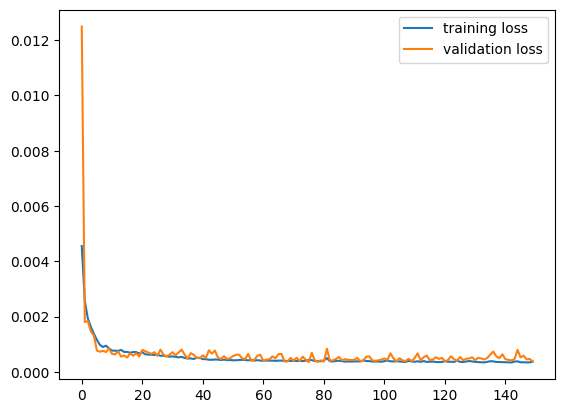

In [ ]:
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.show()

# Inspection Space

In [ ]:
temp = test_data[(test_data.time >= '2023-06-22 01:00:00') & (test_data.time <= '2023-06-23 00:00:00')].drop(columns = 'time')


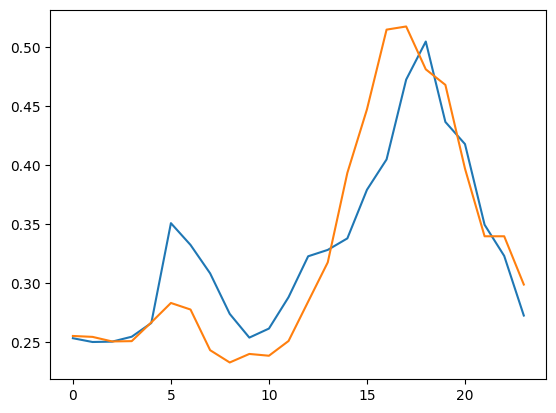

In [ ]:
temp = test_data[(test_data.time >= '2023-06-25 01:00:00') & (test_data.time <= '2023-06-26 00:00:00')].drop(columns = 'time')
X_train = temp[[col for col in temp.columns if col != 'value']]
y_train = temp.value
X_train = torch.from_numpy(X_train.values).to(torch.float64)
y_train = torch.from_numpy(y_train.values).to(torch.float64)


pred = model(X_train)

plt.plot(pred.detach().numpy())
plt.plot(y_train)

In [ ]:
test_data[test_data.value.isna() == False]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8
0,2023-06-01 01:00:00,0.281151,8.1,76,4.2,6.1,0.0,0,0,0,...,0.0,0.0,0.733333,-0.341667,-0.458333,6,NaN,NaN,NaN,NaN
1,2023-06-01 02:00:00,0.280982,7.2,77,3.5,5.3,0.0,0,0,0,...,0.0,0.0,0.733333,-0.341667,-0.416667,6,NaN,NaN,NaN,NaN
2,2023-06-01 03:00:00,0.291136,6.5,78,2.9,4.3,0.0,0,0,0,...,0.0,0.0,0.733333,-0.341667,-0.375000,6,NaN,NaN,NaN,NaN
3,2023-06-01 04:00:00,0.302375,5.6,80,2.5,3.2,0.0,0,0,0,...,0.0,0.0,0.733333,-0.341667,-0.333333,6,NaN,NaN,NaN,NaN
4,2023-06-01 05:00:00,0.345335,5.0,80,1.9,2.5,0.0,0,0,0,...,0.0,0.0,0.733333,-0.341667,-0.291667,6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,2023-06-28 12:00:00,0.268544,23.2,55,13.7,26.0,0.0,0,0,0,...,124.0,919.1,-0.041667,-0.358333,0.000000,6,0.269530,0.264456,0.199906,0.361072
660,2023-06-28 13:00:00,0.287403,25.0,49,13.5,28.0,0.0,0,0,0,...,126.0,921.1,-0.041667,-0.358333,0.041667,6,0.294530,0.307758,0.236662,0.383696
661,2023-06-28 14:00:00,0.329631,26.3,45,13.4,29.2,0.0,0,0,0,...,127.0,895.6,-0.041667,-0.358333,0.083333,6,0.344252,0.378039,0.275303,0.320148
662,2023-06-28 15:00:00,0.381390,28.2,40,13.3,30.9,0.0,0,0,0,...,123.0,861.7,-0.041667,-0.358333,0.125000,6,0.392683,0.444130,0.333983,0.237062


In [ ]:
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score

In [ ]:
weather_cols = ['dewpoint_2m','relativehumidity_2m','temperature_2m',
                'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
                'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
                'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance']
weather_dictionary = {col:[] for col in weather_cols}

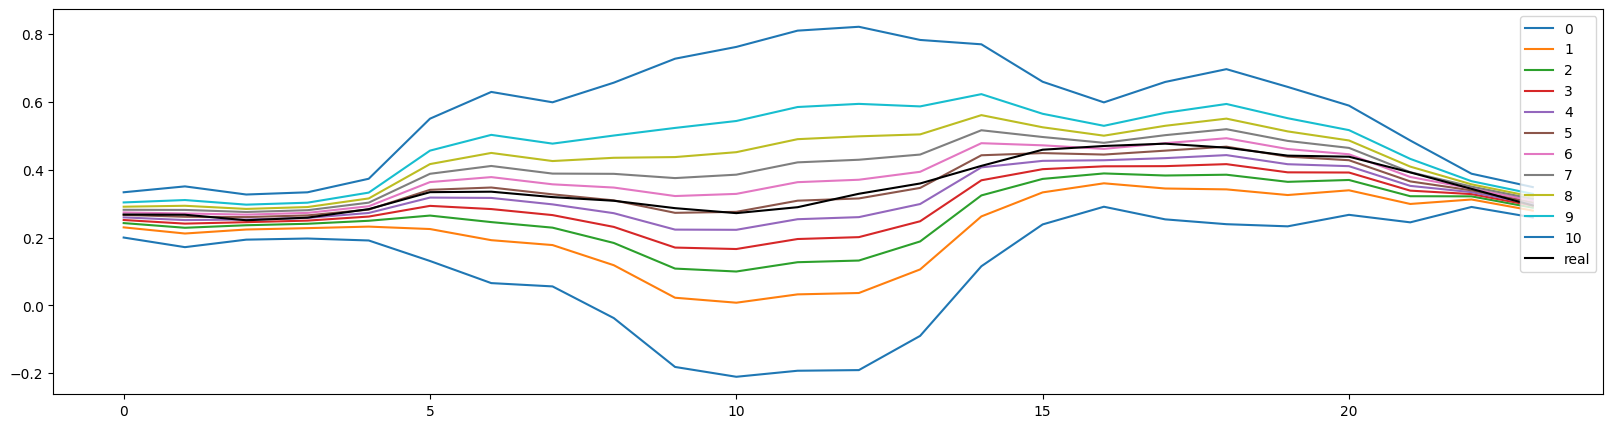

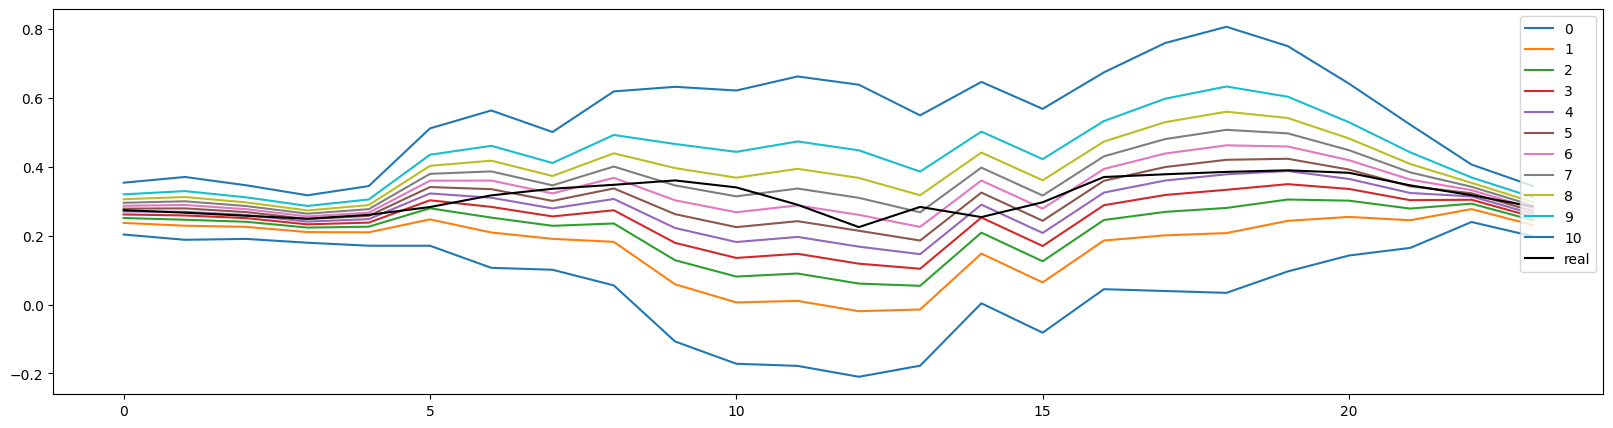

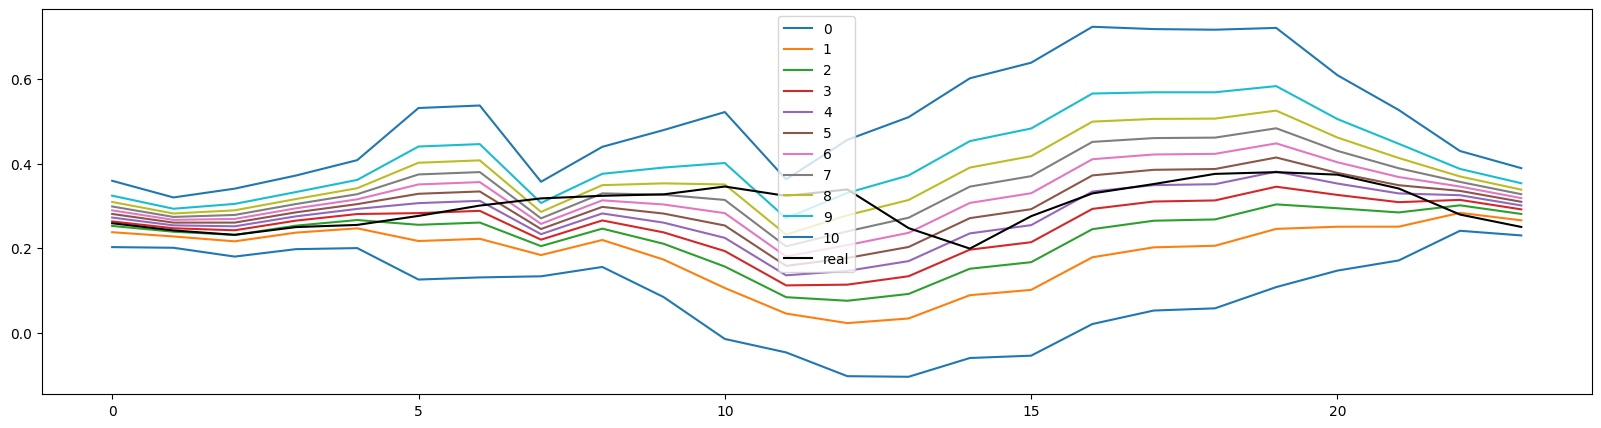

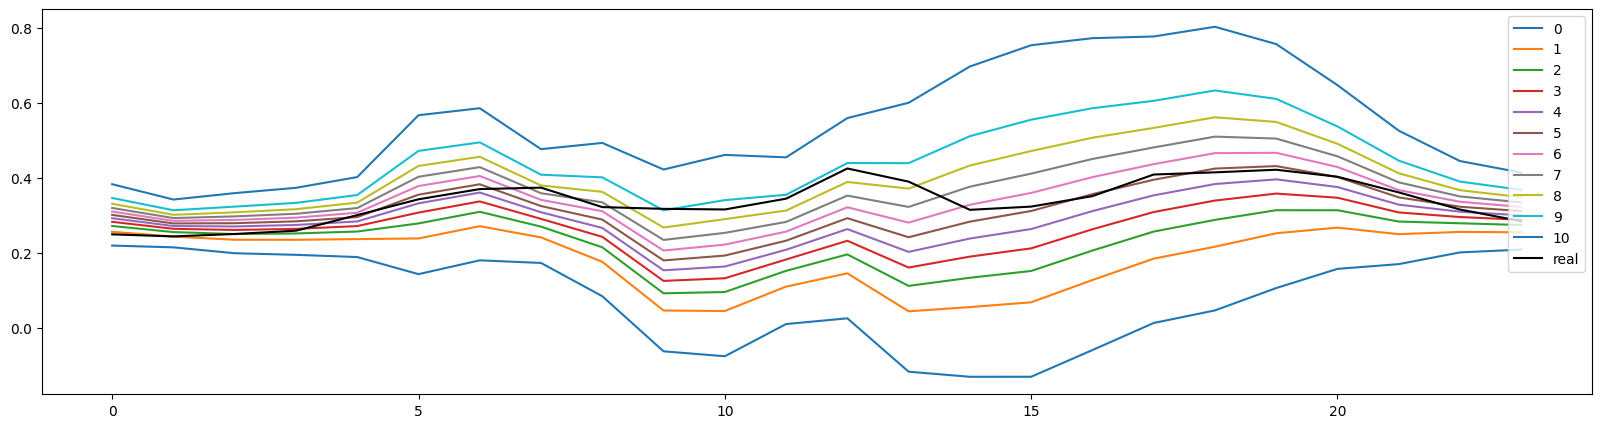

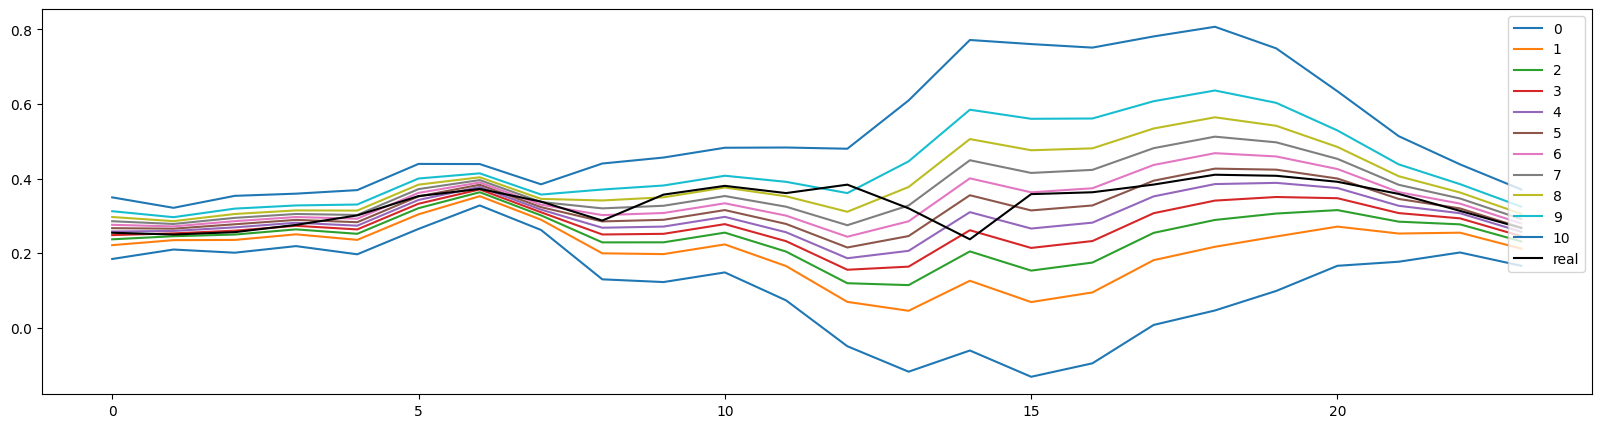

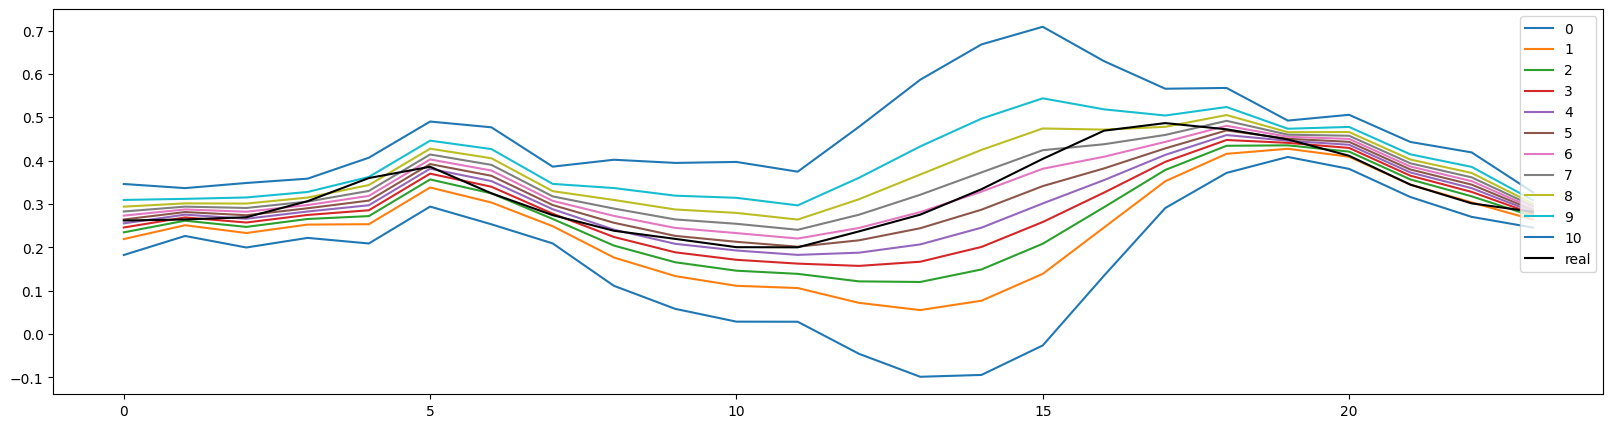

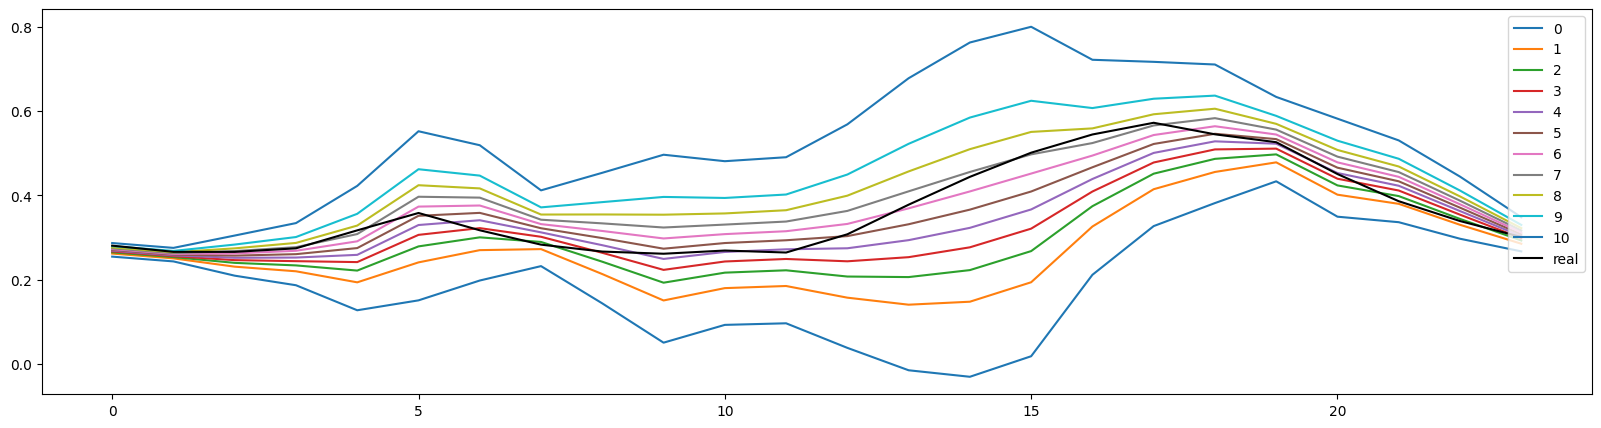

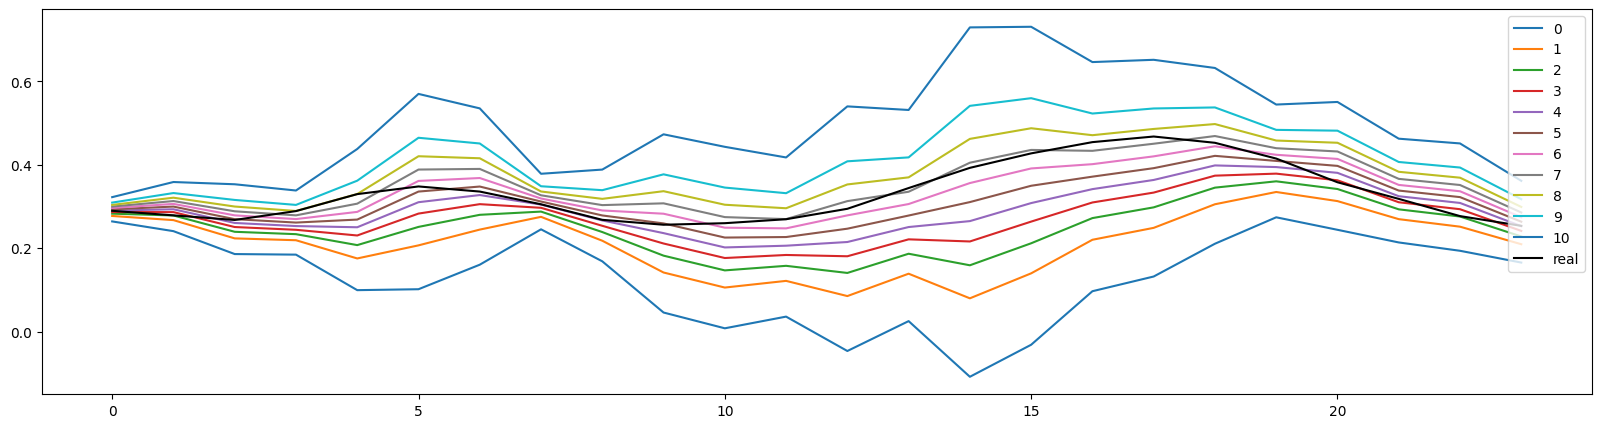

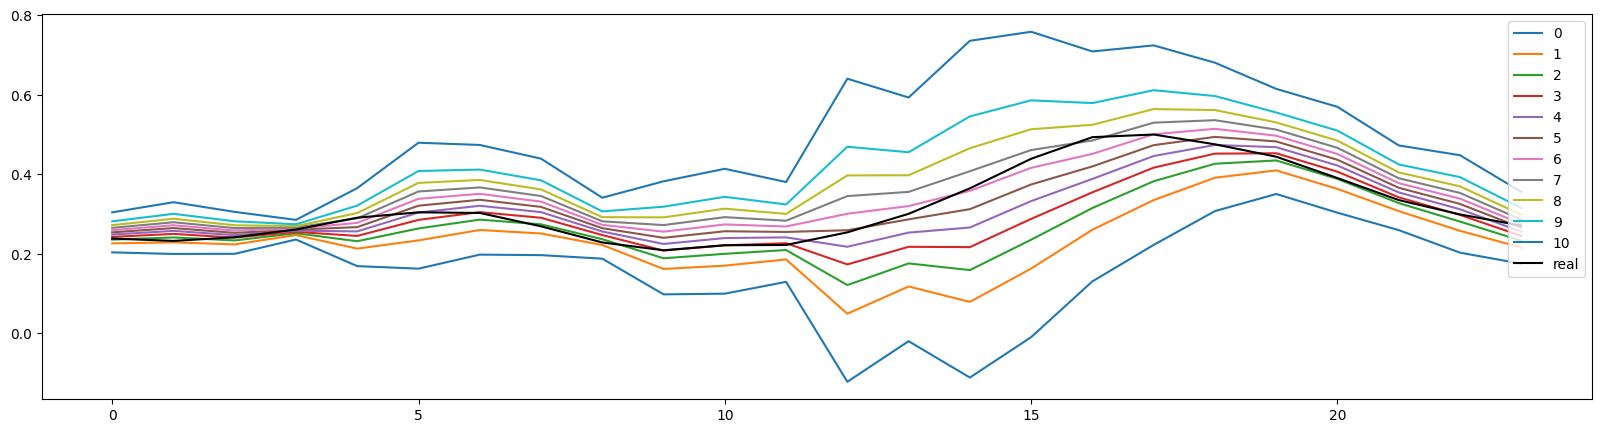

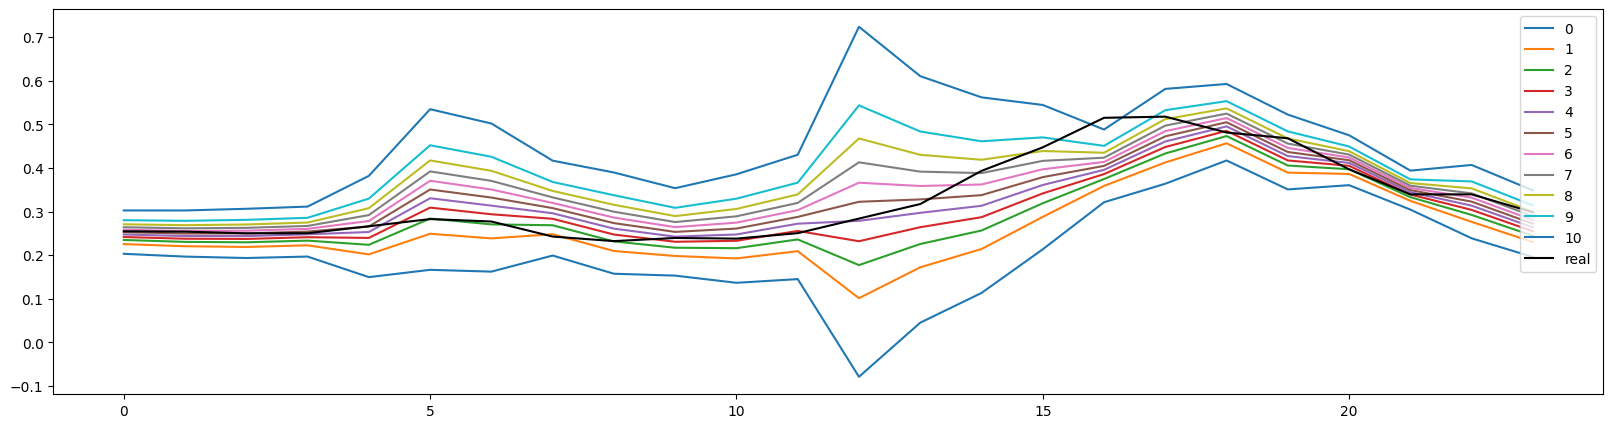

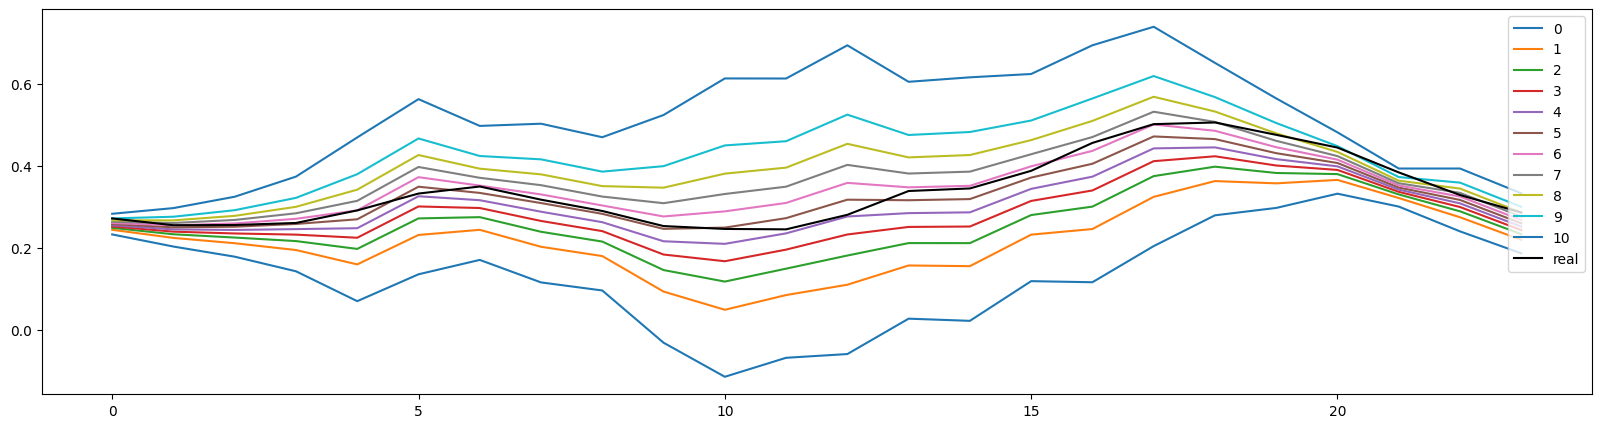

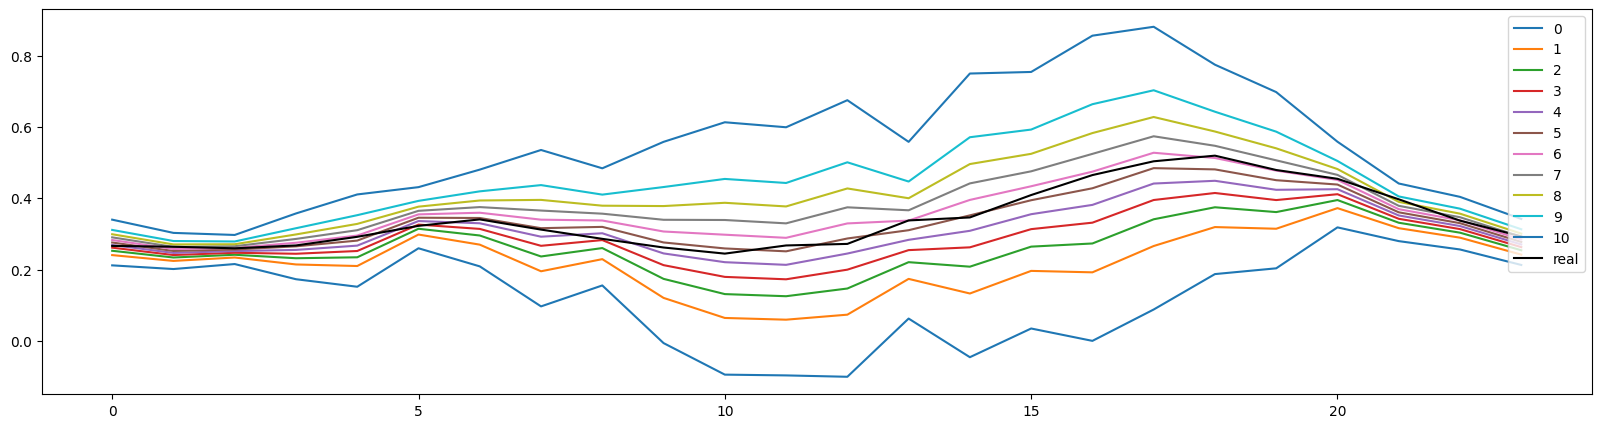

In [ ]:
daily_crps = []

for day in range(17, 29):
  test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1))
                    & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')

  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  hourly_deviations = []
  meanies = []
  std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)

  plt.figure(figsize = (20,5))
  vals = []
  for i in range(0, 11):
    q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

    pred2 = preds + (2 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

    vals.append(pred2)
    plt.plot(pred2.detach().numpy(), label = str(i))

  plt.plot(y_test, color = 'black', label = 'real')
  plt.legend()
  plt.show()

  for col in weather_cols:
    weather_data = test_df[col].values
    weather_dictionary[col].append(test_df[col].std())


  # pred = torch.concat(vals, dim = 1).detach().numpy()

  # submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
  # submission['timestamp'] = pd.date_range(start = '2023-06-{0:2d} 01:00:00'.format(day - 1),
  #                                         end =  '2023-06-{0:2d} 00:00:00'.format(day),
  #                                         freq='H',
  #                                         tz = states['ga']['local_time_zone']
  #                                         )

  # submission[['p' + str(i*10) for i in range(11)]] = pred

  obs = y_test.detach().numpy()
  fx = pred
  fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()

  crps = continuous_ranked_probability_score(obs, fx, fx_prob)
  daily_crps.append(crps)
  # submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/_new_model_June_{:02d}.csv".format(day))

# plt.plot(,daily_crps)
# plt.show()

In [ ]:
# plt.plot(range(22,29),daily_crps, label = 'crps', color = 'black')
corrs = []
for col in weather_cols:
  corrs.append(np.corrcoef(daily_crps, weather_dictionary[col])[0][1])
print(len(corrs), len(weather_cols))
plt.figure(figsize = (25,5))
plt.scatter(weather_cols,corrs)
plt.show()

ValueError: ignored

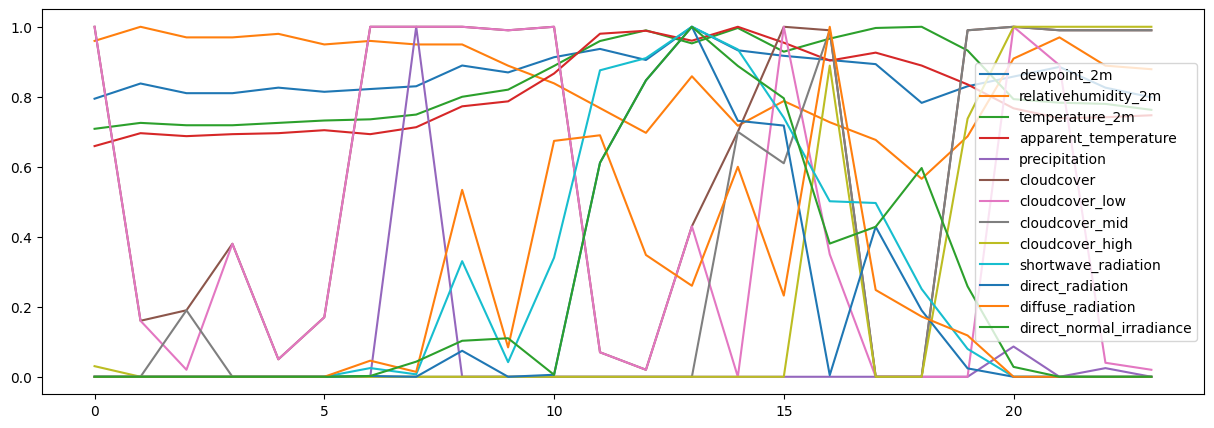

In [ ]:
day = 23
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  weather_dictionary[col].append(test_df[col].std())
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

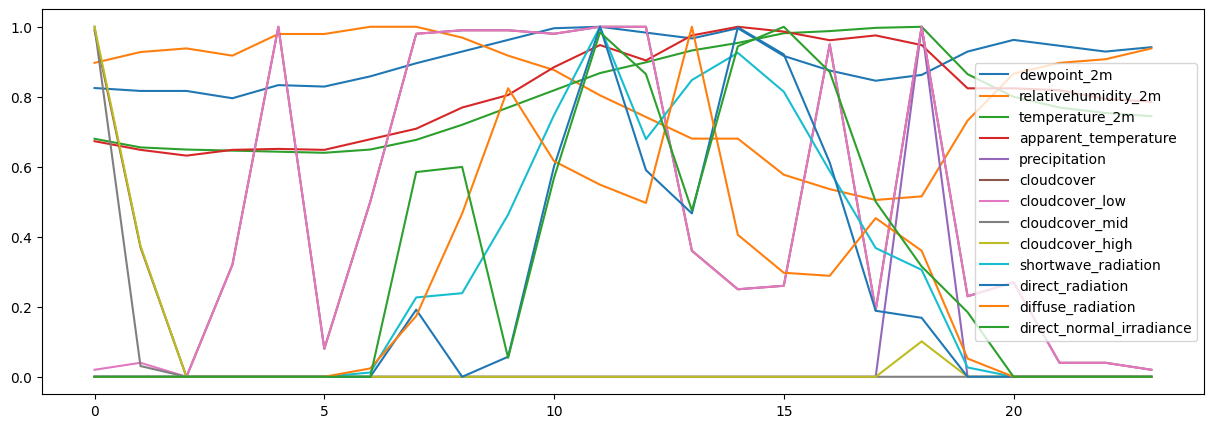

In [ ]:
day = 24
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

In [ ]:
# current_day = -1
# biases = []
# predictions = []
# observations = []
# for i in range(lookback_start, lookback_end + 1):
#   test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
#   X_test = test_df[[col for col in test_df.columns if col != 'value']]
#   y_test = test_df.value
#   X_test = torch.from_numpy(X_test.values).to(torch.float64)
#   y_test = torch.from_numpy(y_test.values).to(torch.float64)

#   preds = model(X_test)

#   predictions.append(preds)
#   observations.append(y_test)

# mean_pred = torch.zeros((24,1))
# mean_obs = torch.zeros((24,1))

# for i in range(lookback_dim):
#   mean_pred += predictions[i]
#   mean_obs += observations[i].view(24,1)

# mean_obs /= lookback_dim
# mean_pred /= lookback_dim

# test_df = test_data[-23-24:-23].drop(columns = 'time')
# X_test = test_df[[col for col in test_df.columns if col != 'value']]
# y_test = test_df.value
# X_test = torch.from_numpy(X_test.values).to(torch.float64)
# y_test = torch.from_numpy(y_test.values).to(torch.float64)

# preds = model(X_test)

# hourly_deviations = []
# meanies = []
# std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


# vals = []
# for i in range(0, 11):
#   q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
#   bias = mean_pred - mean_obs
#   corrected_mean = preds - bias


#   pred2 = preds + std_hour * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

#   vals.append(pred2)
#   plt.plot(pred2.detach().numpy(), label = str(i))

# plt.legend()
# plt.show()

# pred = torch.concat(vals, dim = 1).detach().numpy()


# BIAS CORRECTION AND SUBMISSION

In [ ]:
from timezonefinder import TimezoneFinder
states = {
    'hi': {
        "lat":21.446911,
        "lon":-158.188736,
        "fresh_data_time":'12',
    },
    'or': {
        "lat":45.114559,
        "lon":-123.204903,
        "fresh_data_time":'12',
    },
    'tx': {
        "lat":29.424122,
        "lon":-98.493629,
        "fresh_data_time":'06',
    },
    'ga': {
        "lat":31.044241,
        "lon":-84.879128,
        "fresh_data_time":'06',
    },

}
tf = TimezoneFinder(in_memory=True)
for state in states:
  local_time_zone = tf.timezone_at(lng = states[state]['lon'], lat = states[state]['lat'])
  states[state]['local_time_zone'] = local_time_zone


tx_lon = -98.493629
tx_lat = 29.424122
ga_lon = -84.879128
ga_lat = 31.044241
or_lon = -123.204903
or_lat = 45.114559
hi_lat = 21.446911
hi_lon = -158.188736



from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return

In [ ]:
test_df = test_data[-23-24-24:-23-24]#.drop(columns = 'time')

In [ ]:
current_day = -1
biases = []
predictions = []
observations = []
for i in range(lookback_start, lookback_end + 1):
  test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  predictions.append(preds)
  observations.append(y_test)

mean_pred = torch.zeros((24,1))
mean_obs = torch.zeros((24,1))

for i in range(lookback_dim):
  mean_pred += predictions[i]
  mean_obs += observations[i].view(24,1)

mean_obs /= lookback_dim
mean_pred /= lookback_dim

In [ ]:
# test_data[-23-24-24-1:-23-24-1]

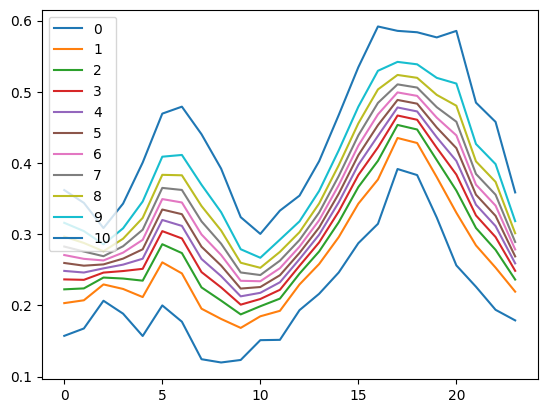

In [ ]:
# j = 1
# trial_x, trial_y = X_test[-24 * (j): -24 * (j-1)], y_test[-24 * (j): -24 * (j-1)]

test_df = test_data[-23-24-24:-23-24].drop(columns = 'time')
X_test = test_df[[col for col in test_df.columns if col != 'value']]
y_test = test_df.value
X_test = torch.from_numpy(X_test.values).to(torch.float64)
y_test = torch.from_numpy(y_test.values).to(torch.float64)

preds = model(X_test)#torch.from_numpy(X).to(torch.float64))#.shape

hourly_deviations = []
meanies = []
std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)#new_df[new_df['hour'] == float(i)]['value'].std()


vals = []
for i in range(0, 11):
  q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
  bias = mean_pred - mean_obs
  corrected_mean = preds - bias#(preds - mean)


  pred2 = preds +  (2 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

  vals.append(pred2)
  plt.plot(pred2.detach().numpy(), label = str(i))

plt.legend()
plt.show()

pred = torch.concat(vals, dim = 1).detach().numpy()

# Submission Block

In [ ]:
from datetime import datetime


In [ ]:
submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
submission['timestamp'] = pd.date_range(start = '2023-07-01 01:00:00',
                                         end =  '2023-07-02 00:00:00',
                                         freq='H',
                                         tz = states['or']['local_time_zone']
                                         )
submission[['p' + str(i*10) for i in range(11)]] = pred

submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/or_pytorch2_submission_{}.csv".format(datetime.now()))

upload_function(submission.set_index('timestamp'),'or')